# Modeling the Refined Data
Using Clustering then Classification Model

### Importing Libraries and Data

In [226]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import calinski_harabaz_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm_notebook as tqdm

#### Loading the Profiles

In [230]:
# Loading in the cleaned DF
with open("refined_profiles.pkl",'rb') as fp:
    df = pickle.load(fp)

# Viewing the DF    
df.head()

,Bios,Movies,Religion,Music,Politics,Social Media,Sports,Age
0,Typical twitter fanatic. Infuriatingly humble thinker. Lifelong coffee practitioner. Organizer.,"[Thriller, Action]",Buddhist,"[Gospel, Pop, Rock]",Progressive,"[Twitter, Reddit, Instagram]","[Basketball, Football, Hockey]",19
1,Web junkie. Analyst. Infuriatingly humble introvert. Food nerd. Lifelong music fanatic. Coffee lover.,"[Comedy, Drama]",Spiritual,"[HipHop, Pop]",Conservative,"[Twitter, Facebook]","[Basketball, Soccer, Hockey]",19
2,Avid web maven. Food practitioner. Gamer. Twitter fanatic. Pop culture scholar. Zombie evangelist.,"[Horror, Comedy]",Christian,"[HipHop, Rock]",Moderate,"[Reddit, Youtube]","[Baseball, Football]",21
3,Twitteraholic. Extreme web fanatic. Food buff. Infuriatingly humble entrepreneur.,"[Adventure, Comedy]",Agnostic,[Rock],Moderate,"[Facebook, Youtube]","[Basketball, Football, Hockey]",25
4,Bacon enthusiast. Falls down a lot. Freelance social media fan. Infuriatingly humble introvert.,"[Action, Adventure, Drama]",Hindu,"[Latin, Rock, HipHop]",Conservative,"[Twitter, TikTok, Youtube]","[Hockey, Football, Basketball]",19


## Clustering the Refined Data

### Vectorizing

In [231]:
def string_convert(x):
    """
    First converts the lists in the DF into strings
    """
    if isinstance(x, list):
        return ' '.join(x)
    else:
        return x
    
# Looping through the columns and applying the function
for col in df.columns:
    df[col] = df[col].apply(string_convert)

In [232]:
df

,Bios,Movies,Religion,Music,Politics,Social Media,Sports,Age
0,Typical twitter fanatic. Infuriatingly humble thinker. Lifelong coffee practitioner. Organizer.,Thriller Action,Buddhist,Gospel Pop Rock,Progressive,Twitter Reddit Instagram,Basketball Football Hockey,19
1,Web junkie. Analyst. Infuriatingly humble introvert. Food nerd. Lifelong music fanatic. Coffee lover.,Comedy Drama,Spiritual,HipHop Pop,Conservative,Twitter Facebook,Basketball Soccer Hockey,19
2,Avid web maven. Food practitioner. Gamer. Twitter fanatic. Pop culture scholar. Zombie evangelist.,Horror Comedy,Christian,HipHop Rock,Moderate,Reddit Youtube,Baseball Football,21
3,Twitteraholic. Extreme web fanatic. Food buff. Infuriatingly humble entrepreneur.,Adventure Comedy,Agnostic,Rock,Moderate,Facebook Youtube,Basketball Football Hockey,25
4,Bacon enthusiast. Falls down a lot. Freelance social media fan. Infuriatingly humble introvert.,Action Adventure Drama,Hindu,Latin Rock HipHop,Conservative,Twitter TikTok Youtube,Hockey Football Basketball,19
5,Pop culture junkie. Tv buff. Reader. Friendly travel expert. Incurable twitteraholic. Social media ninja. Coffee enthusiast. Internet specialist.,Adventure Comedy Drama,Hindu,Pop Rock,Liberal,Instagram Youtube,Baseball Football,23
6,Typical thinker. Amateur explorer. Reader. Extreme student. Tv fanatic. Social media ninja.,Action Adventure Drama,Other,Pop Rock,Liberal,Pinterest Twitter Youtube,Baseball Football,20
7,Zombie maven. Travel geek. Professional social media buff. Avid pop culture lover.,Action Thriller Drama,Spiritual,Pop Rock,Liberal,Reddit TikTok,Soccer Hockey,22
8,Lifelong introvert. General travel maven. Hipster-friendly web trailblazer. Writer. Alcohol fan. Student. Communicator. Coffee guru.,Action Comedy Documentary,Hindu,Latin Rock HipHop,Conservative,Facebook,Baseball,19
9,Travel ninja. Amateur pop culture evangelist. Web fanatic. Freelance communicator. Zombie geek.,Comedy Drama,Hindu,Country Pop EDM,Conservative,Reddit,Hockey Football Basketball,29


In [123]:
def vectorization(df, columns):
    """
    Using recursion, iterate through the df until all the categories have been vectorized
    """
    column_name = columns[0]
    
    # Checking if the column name has been removed already
    if column_name not in ['Bios', 'Movies','Religion', 'Music', 'Politics', 'Social Media', 'Sports']:
        return df
    
    if column_name in ['Religion', 'Politics']:
        df[column_name.lower()] = df[column_name].cat.codes
        
        df = df.drop(column_name, 1)
        
        return vectorization(df, df.columns)
    
    else:
        # Instantiating the Vectorizer
        vectorizer = CountVectorizer()
        
        # Fitting the vectorizer to the Bios
        x = vectorizer.fit_transform(df[column_name])

        # Creating a new DF that contains the vectorized words
        df_wrds = pd.DataFrame(x.toarray(), columns=vectorizer.get_feature_names())

        # Concating the words DF with the original DF
        new_df = pd.concat([df, df_wrds], axis=1)

        # Dropping the column because it is no longer needed in place of vectorization
        new_df = new_df.drop(column_name, axis=1)
        
        return vectorization(new_df, new_df.columns) 

In [124]:
# Creating the vectorized DF
vect_df = vectorization(df, df.columns)

In [125]:
# Scaling
scaler = MinMaxScaler()

vect_df = pd.DataFrame(scaler.fit_transform(vect_df), index=vect_df.index, columns=vect_df.columns)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [126]:
vect_df

,Age,advocate,aficionado,alcohol,alcoholaholic,amateur,analyst,animals,apathy,avid,...,snapchat,tiktok,twitter,youtube,baseball,basketball,football,hockey,other,soccer
0,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,0.032258,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,0.096774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,0.225806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,0.032258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
5,0.161290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
6,0.064516,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
7,0.129032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.032258,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.354839,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


### PCA

In [127]:
from sklearn.decomposition import PCA

# Instantiating PCA
pca = PCA()

# Fitting and Transforming the DF
df_pca = pca.fit_transform(vect_df)

# Finding the exact number of features that explain at least 99% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_9 = len(total_explained_variance[total_explained_variance>=.99])
n_to_reach_9 = vect_df.shape[1] - n_over_9

print("PCA reduces the # of features from", vect_df.shape[1], 'to', n_to_reach_9)

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_9)

# Fitting and transforming the dataset to the stated number of features
df_pca = pca.fit_transform(vect_df)

# Seeing the variance ratio that still remains after the dataset has been reduced
pca.explained_variance_ratio_.cumsum()[-1]

PCA reduces the # of features from 146 to 111


0.9898406456464586

### Performing Hierarchical Agglomerative Clustering
- First finding the optimum number of clusters

In [188]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 11, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
ch_scores = []

s_scores = []

db_scores = []

# The DF for evaluation
eval_df = df_pca

# Looping through different iterations for the number of clusters
for i in tqdm(cluster_cnt):
    
    # Clustering with different number of clusters
    clust = AgglomerativeClustering(n_clusters=i, linkage='complete')
    
    clust.fit(eval_df)
    
    cluster_assignments = clust.labels_
    
    # Appending the scores to the empty lists
    ch_scores.append(calinski_harabaz_score(eval_df, cluster_assignments))
    
    s_scores.append(silhouette_score(eval_df, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(eval_df, cluster_assignments))

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_d

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


### Helper Function to Evaluate the Clusters

In [189]:
def cluster_eval(y, x):
    """
    Prints the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('bmh')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()

### Evaluation of Clusters

The Calinski-Harabasz Score (find max score):
Max Value:
Cluster #    Cluster Score
3       42.17597

Min Value:
Cluster #    Cluster Score
2      19.756939


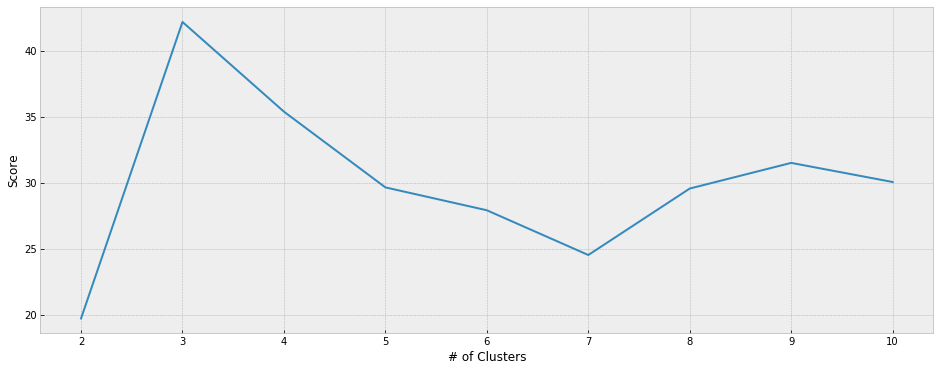


The Silhouette Coefficient Score (find max score):
Max Value:
Cluster #    Cluster Score
3       0.013892

Min Value:
Cluster #    Cluster Score
7       0.001629


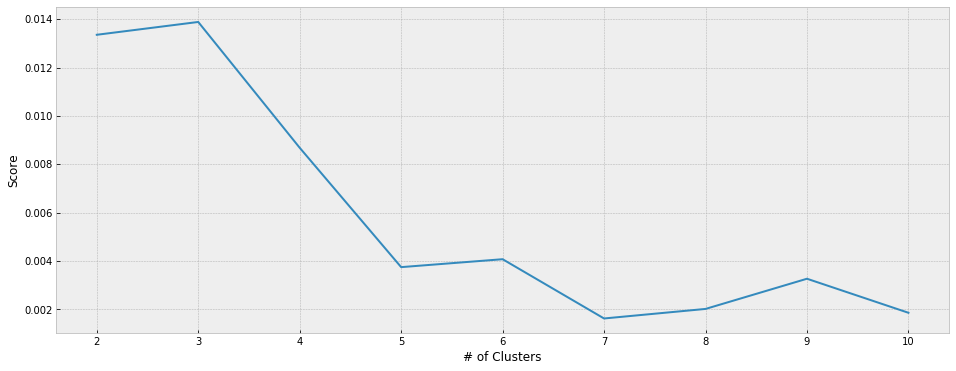


The Davies-Bouldin Score (find minimum score):
Max Value:
Cluster #    Cluster Score
2        15.2082

Min Value:
Cluster #    Cluster Score
7       9.202777


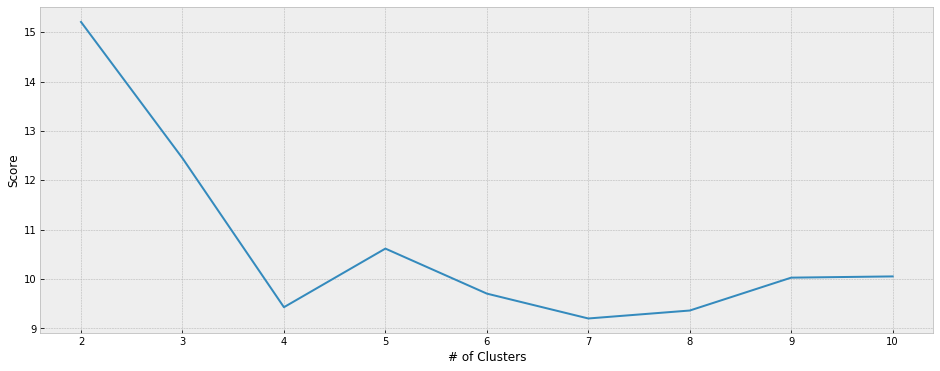

In [190]:
print("The Calinski-Harabasz Score (find max score):")
cluster_eval(ch_scores, cluster_cnt)

print("\nThe Silhouette Coefficient Score (find max score):")
cluster_eval(s_scores, cluster_cnt)

print("\nThe Davies-Bouldin Score (find minimum score):")
cluster_eval(db_scores, cluster_cnt)

### Running HAC
Again but with the optimum cluster count

In [234]:
# Instantiating HAC based on the optimum number of clusters found
hac = AgglomerativeClustering(n_clusters=3, linkage='complete')

# Fitting
hac.fit(df_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Assigning the clusters to each profile
df['Cluster #'] = cluster_assignments

vect_df['Cluster #'] = cluster_assignments

#### Exporting the Clustered DF and Vectorized DF

In [236]:
with open("refined_cluster.pkl",'wb') as fp:
    pickle.dump(df, fp)
    
with open("vectorized_refined.pkl", 'wb') as fp:
    pickle.dump(vect_df, fp)

## Classification of the New Profile

### Importing the Different Classification Models

In [214]:
# Importing 3 models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

### Train, test, splitting

In [215]:
# Assigning the split variables
X = vect_df.drop(["Cluster #"], 1)
y = vect_df['Cluster #']

# Train, test, split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Finding the Best Model
- Dummy (Baseline Model)
- KNN
- SVM
- NaiveBayes
- Logistic Regression
- Adaboost

In [216]:
# Dummy
dummy = DummyClassifier(strategy='stratified')

# KNN
knn = KNeighborsClassifier()

# SVM
svm = SVC(gamma='scale')

# NaiveBayes
nb = ComplementNB()

# Logistic Regression
lr = LogisticRegression()

# Adaboost
adab = AdaBoostClassifier()

# List of models
models = [dummy, knn, svm, nb, lr, adab]

# List of model names
names = ['Dummy', 'KNN', 'SVM', 'NaiveBayes', 'Logistic Regression', 'Adaboost']

# Zipping the lists
classifiers = dict(zip(names, models))

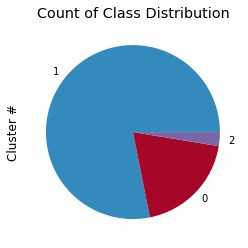

In [217]:
# Visualization of the different cluster counts
vect_df['Cluster #'].value_counts().plot('pie', title='Count of Class Distribution');

Since we are dealing with an imbalanced dataset _(because each cluster is not guaranteed to have the same amount of profiles)_, we will resort to using the __Macro Avg__ and __F1 Score__ for evaluating the performances of each model.

In [218]:
# Dictionary containing the model names and their scores
models_f1 = {}

# Looping through each model's predictions and getting their classification reports
for name, model in tqdm(classifiers.items()):
    # Fitting the model
    model.fit(X_train, y_train)
    
    print('\n'+ name + ' (Macro Avg - F1 Score):')
    
    # Classification Report
    report = classification_report(y_test, model.predict(X_test), output_dict=True)
    f1 = report['macro avg']['f1-score']
    
    # Assigning to the Dictionary
    models_f1[name] = f1
    
    print(f1)


Dummy (Macro Avg - F1 Score):
0.32517149390243905

KNN (Macro Avg - F1 Score):
0.7747566909975668

SVM (Macro Avg - F1 Score):
0.7893287181978682

NaiveBayes (Macro Avg - F1 Score):
0.8064587084629236

Logistic Regression (Macro Avg - F1 Score):
0.7885312711363918


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



Adaboost (Macro Avg - F1 Score):
0.670515340761144



#### Model with the Best Performance

In [219]:
print(max(models_f1, key=models_f1.get), 'Score:', max(models_f1.values()))

NaiveBayes Score: 0.8064587084629236


### Fitting the Best Model to our Dataset
_(Optional: Tune the model with GridSearch)_

In [224]:
# Fitting the model
nb.fit(X, y)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

### Saving the Classification Model
For future use

In [225]:
from joblib import dump

dump(nb, "refined_model.joblib")

['refined_model.joblib']